# Spatial and temporal resampling of gridded ECMWF data onto a satellite's swath

For the retrieval of physical parameters in the atmosphere via Optimal Estimation, we need apriori knowlegdge of the quantity we want to retrieve; this apriori knowledge can be obtained from a forecast model. 

ECMWF's forecasts are available in different spatial and temporal resolutions, in particular in this notebook we work with a *0.25/0.25* regular *lon/lat* grid in **space** and 16 steps for 2 [analysis](https://www.ecmwf.int/en/research/data-assimilation) times per day, time/step combination gives **temporal** coverage of data every hour: 

- *time* is the reference time (time at which the analysis is performed and observations are used to update the model).
- *step* is related to the time steps that describe the temporal evolution of the forecast model.

Once the ECMWF's data is available with a given spatial/temporal resolution, we focus on the satellite observations, to be specific the locations (i.e. longitude and latitude of each observation); because the satellite does not care much about grids, we rely on it's swath definition: how the instrument *samples* in space and time.

Different instruments (and data providers) might have different versions of how to describe the swath (however the concept of swath is happily enough, unique); in our case we use CMSAF [data](https://wui.cmsaf.eu/safira/action/viewDoiDetails?acronym=FCDR_MWI_V003) (i.e. Brightness Temperatures). 
Each specific sample (observation) is made at a specific time and location (*time*, *lon*, *lat*), so our goal is: to interpolate the ECMWF's variable (which is defined on the regular *lon/lat* grid) onto the specific time/locations in our satellite's swath. 

In this notebook we use: 
- [Pyresample](https://pyresample.readthedocs.io/en/latest/)'s functionality to efficiently resample data from a regular grid onto a swath.
- [xarray](https://docs.xarray.dev/en/stable/)'s functionality to handle high dimensional datasets and to perform the time interpolation. 

First we will import the needed libraries and packages:

In [1]:
import sys
import os

import xarray as xr

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import pyproj
import pyresample
from pyresample import create_area_def, load_area, data_reduce, utils, AreaDefinition
from pyresample.geometry import SwathDefinition, GridDefinition
from pyresample.kd_tree import resample_nearest, resample_gauss 
from pyresample.bilinear import XArrayBilinearResampler, NumpyBilinearResampler #



%matplotlib inline


I might use *Dask*'s functionality later on; when working with large datasets, *xarray* offers *Dask*'s capabilities to chunk, out-of-memory computation and parallel processing.

Here we just create a computing cluster:

In [2]:
os.environ["MALLOC_TRIM_THRESHOLD_"] = "0"#"65536"

from dask.distributed import Client, progress, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/mario/Documents/work/code/git/ExtractApriori/dask-worker-space/worker-wtj6pf4w', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mario/Documents/work/code/git/ExtractApriori/dask-worker-space/worker-n9f9quq8', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mario/Documents/work/code/git/ExtractApriori/dask-worker-space/worker-z8iapafv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mario/Documents/work/code/git/ExtractApriori/dask-worker-space/worker-njj16vn7', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.30 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38675,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.30 GiB
Comm: tcp://127.0.0.1:45963,Total threads: 2
Dashboard: http://127.0.0.1:44055/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:45481,


We define some directories for easy access to the datasets:

In [3]:
# Satellite data:
#dataSatDir = '/home/mario/Data/CMSAF/ssims/F16/'
#dataSatDir = '/home/mario/Data/CMSAF/ssims/F16/ORD47662/'
dataSatDir = '/home/mario/Data/CMSAF/ssims/F16/test_02Oct2014/'
#dataSatDir = '/nobackup/users/echeverr/data/cmsaf/ssmis/F16/'
#fileSatID = 'BTRin20140909000000324SSF1601GL.nc'

# ECMWF data:
#dataECMWFDir ='/home/mario/Data/Covariance_means/MARS_api_data/datasetsApriori/'
#dataECMWFDir = '/nobackup/users/echeverr/data/ECMWF_era5/MARS_api_data/datasetsApriori/'
dataECMWFDir ='/home/mario/Data/Covariance_means/MARS_api_data/datasetsAprioriRegGrid/'

# REMOVE THE FOLLOWING ONCE YOU GET ECMWF'S DATASETS IN REGULAR GRID:
#Test only:

auxDataECMWFDir = '/home/mario/Data/Covariance_means/MARS_api_data/ERA5_data/datasets/'


sys.path.append('support') # where supporting_routines_m live

import support_routines 

# Data preparation

We have two sources of data that we care about in this notebook: ECMWF's data and satellite's swath definition (we do not use explicitely the observations per se, rather we use the location of the observations, the points where we want to resample and interpolate our ECMWF data).

First we load ECMWF's datasets using xarray; notice we open *profile* like datasets (i.e. with variables defined in pressure or model levels) and *surface* like datasets (i.e. with variables defined on the surface, e.g. 10m wind speed or 2m temperature).

I then merge them into a single working dataset; shared dimensions and coordinates are automatically handled by xarray:

In [4]:
profile_info = xr.open_mfdataset(dataECMWFDir+'profiles*.grib', 
                                 engine="cfgrib") #, chunks={'time': 50, 'latitude': 50, 'longitude': 200})
surface_info = xr.open_mfdataset(dataECMWFDir+'surface*.grib', 
                                 engine="cfgrib") #, chunks={'time': 50,'latitude': 50, 'longitude': 200})


work_ds = profile_info.merge(surface_info).copy()

work_ds

<xarray.Dataset>
Dimensions:        (time: 14, step: 16, isobaricInhPa: 25, latitude: 724,
                    longitude: 1440)
Coordinates:
  * time           (time) datetime64[ns] 2014-10-01 ... 2014-10-07T12:00:00
  * step           (step) timedelta64[ns] 03:00:00 04:00:00 ... 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 90.25 90.5 90.75
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     (time, step) datetime64[ns] dask.array<chunksize=(14, 16), meta=np.ndarray>
    surface        float64 ...
Data variables:
    t              (time, step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(14, 16, 25, 724, 1440), meta=np.ndarray>
    q              (time, step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(14, 16, 25, 724, 1440), meta=np.ndarray>
    u10n           (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    v10n           (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    sp             (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    t2m            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    lsm            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    skt            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-10-07T09:19 GRIB to CDM+CF via cfgrib-0.9.9...

In [5]:
# This block is only auxiliary: I used "cdo" to convert 
# a reduced Gaussian grid dataset (N320) into a 
# regular 0.25x0.25 deg**2 grid (ECMWF MARS was not
# available at the time of this test, so I could not 
# download the dataset in the regular grid).
# "cdo" uses a bilinear interpolation (cdo documentation); 
# but the resulting grid (lon, lat) has slight 
# differences respect to the ECMWF regular grid.

# In this block I just take the (lon,lat) from another 
# 0.25x0.25 deg**2 ECMWF dataset and replace my cdo 
# regular grid with it for consistency.

aux_info = xr.open_mfdataset(auxDataECMWFDir+'surface*.grib', 
                                 engine="cfgrib")
work_ds['latitude'] = aux_info['latitude'][::-1] # The order in cdo is different
work_ds['longitude'] = aux_info['longitude']
work_ds

<xarray.Dataset>
Dimensions:        (time: 14, step: 16, isobaricInhPa: 25, latitude: 724,
                    longitude: 1440)
Coordinates:
  * time           (time) datetime64[ns] 2014-10-01 ... 2014-10-07T12:00:00
  * step           (step) timedelta64[ns] 03:00:00 04:00:00 ... 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     (time, step) datetime64[ns] dask.array<chunksize=(14, 16), meta=np.ndarray>
    surface        float64 ...
    number         int64 0
Data variables:
    t              (time, step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(14, 16, 25, 724, 1440), meta=np.ndarray>
    q              (time, step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(14, 16, 25, 724, 1440), meta=np.ndarray>
    u10n           (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    v10n           (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    sp             (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    t2m            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    lsm            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    skt            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-10-07T09:19 GRIB to CDM+CF via cfgrib-0.9.9...

Having forecasts separated in *time*/*step* is not useful for our endeavour; we would like to have a single time reference to refer to.
Also we want 24 hours coverage for all the period of interest, therefore we will stack each analysis time (there are 2 analysis per day in the operational forecasts, 00:00 and 12:00) with it's 12 steps.

Because our end goal will be to use ECMWF's forecasts as apriori information in the Optimal Estimation (where we retrieve physical variables using observations), we want to avoid using data next to the analysis time (where observations are being [assimilated](https://www.ecmwf.int/en/research/data-assimilation)) in order to avoid undesired correlations between the apriori and the observations. It is standard to take a window of 3 hours after the analysis for the apriori data (you can notice this in the previous dataset, where the coordinate *step* starts at 03:00).  

We use stack to have a single reference time at the end, we call this new reference time **time2** for simplicity:

In [6]:
ECMWF_ds = work_ds.isel(step=slice(0,12)).stack(time2=("time","step"))
ECMWF_ds

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 25, latitude: 724, longitude: 1440,
                    time2: 168)
Coordinates:
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     (time2) datetime64[ns] dask.array<chunksize=(168,), meta=np.ndarray>
    surface        float64 ...
    number         int64 0
  * time2          (time2) MultiIndex
  - time           (time2) datetime64[ns] 2014-10-01 ... 2014-10-07T12:00:00
  - step           (time2) timedelta64[ns] 03:00:00 04:00:00 ... 14:00:00
Data variables:
    t              (isobaricInhPa, latitude, longitude, time2) float32 dask.array<chunksize=(25, 724, 1440, 168), meta=np.ndarray>
    q              (isobaricInhPa, latitude, longitude, time2) float32 dask.array<chunksize=(25, 724, 1440, 168), meta=np.ndarray>
    u10n           (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    v10n           (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    sp             (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    t2m            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    lsm            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    skt            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-10-07T09:19 GRIB to CDM+CF via cfgrib-0.9.9...

After stacking time/step the new multi-index variable **time2** is not very useful as a time reference, instead we create the new time dimension as the sum of the analysis time and the step (so time + step).

It is useful to point out that *longitude* values for using *pyresample* *must* be refered to a *\[-180, 180\]* range (instead of *\[0, 360\]* ).

In [7]:
ECMWF_ds['time2'] = (work_ds.isel(step=slice(0,12)).time + 
 work_ds.isel(step=slice(0,12)).step).stack(time2=("time","step"))
#ECMWF_ds['longitude'].values = ECMWF_ds.longitude.values - 180.0    # Reset lon to [-180,180]
ECMWF_ds

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 25, latitude: 724, longitude: 1440,
                    time2: 168)
Coordinates:
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     (time2) datetime64[ns] dask.array<chunksize=(168,), meta=np.ndarray>
    surface        float64 ...
    number         int64 0
  * time2          (time2) datetime64[ns] 2014-10-01T03:00:00 ... 2014-10-08T...
Data variables:
    t              (isobaricInhPa, latitude, longitude, time2) float32 dask.array<chunksize=(25, 724, 1440, 168), meta=np.ndarray>
    q              (isobaricInhPa, latitude, longitude, time2) float32 dask.array<chunksize=(25, 724, 1440, 168), meta=np.ndarray>
    u10n           (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    v10n           (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    sp             (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    t2m            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    lsm            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    skt            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-10-07T09:19 GRIB to CDM+CF via cfgrib-0.9.9...

Our ECMWF's dataset seems to be ready to use; we now focus on our satellite observations.

In this notebook we use CMSAF's [data](https://wui.cmsaf.eu/safira/action/viewDoiDetails?acronym=FCDR_MWI_V003) (Temperature Brightness).

CMSAF's data is structured in logical groups, where each group coincides with a group of channels that share the same antenna of the instrument; this logical separation is very useful because different antennas will (likely) have effectively different footprints and sampling on the ground. 

We first open the datasets (7 days of observations, overlaping as much as possible in time with our ECMWF data); the open method in xarray (*open_mfdataset*) will open only the highest level in the datasets, this is useful to grasp the contents of the dataset (*channels*, *time*, *swath*, etc.). Notice that *open_mfdataset* at a difference with the more basic *open_dataset* will load the datasets in a *lazy* way using **Dask** [under the hood](https://docs.xarray.dev/en/stable/user-guide/dask.html) to avoid actually loading the data on memory:  

In [8]:
# Open satellite dataset at highest level (just to get the channels information):

#ds = xr.open_dataset(dataSatDir+fileID)
ds = xr.open_mfdataset(dataSatDir+'*.nc')
ds

<xarray.Dataset>
Dimensions:       (across_track: 360, channel: 26, date: 1, time: 45504)
Coordinates:
  * across_track  (across_track) float32 1.0 1.5 2.0 2.5 ... 179.5 180.0 180.5
  * channel       (channel) int32 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26
  * date          (date) datetime64[ns] 2014-10-02T12:00:00
  * time          (time) datetime64[ns] 2014-10-02T00:00:01 ... 2014-10-02T23...
Data variables:
    central_freq  (channel) float64 dask.array<chunksize=(26,), meta=np.ndarray>
    channel_if1   (channel) float64 dask.array<chunksize=(26,), meta=np.ndarray>
    channel_if2   (channel) float64 dask.array<chunksize=(26,), meta=np.ndarray>
    polarization  (channel) |S50 dask.array<chunksize=(26,), meta=np.ndarray>
    channel_name  (channel) |S50 dask.array<chunksize=(26,), meta=np.ndarray>
    tfrac         (time) float64 dask.array<chunksize=(45504,), meta=np.ndarray>
    rev           (time) float64 dask.array<chunksize=(45504,), meta=np.ndarray>
    qc_scan       (time) float32 dask.array<chunksize=(45504,), meta=np.ndarray>
    pflag         (time) float32 dask.array<chunksize=(45504,), meta=np.ndarray>
    qc_channel    (time, channel) float32 dask.array<chunksize=(45504, 26), meta=np.ndarray>
    rotation      (date) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    md5           (time) |S50 dask.array<chunksize=(45504,), meta=np.ndarray>
Attributes: (12/43)
    title:                       CM SAF FCDR of SSMIS brightness temperatures
    summary:                     This dataset contains Fundamental Climate Da...
    Conventions:                 CF-1.6,ACDD-1.3
    netcdf_library_version:      4.3.3.1 of Mar  7 2016 08:18:19 $
    institution:                 EUMETSAT/CMSAF
    project:                     Satellite Application Facility on Climate Mo...
    ...                          ...
    format_version:              1.1
    tdr_software_rev_num:        10.0
    date_created:                2017-01-11T16:06:36 UTC
    date_modified:               2017-01-11T16:06:36 UTC
    filename:                    BTRin20141002000000324SSF1601GL.nc
    history:                     2017-01-12T12:33:03 UTC: mci-sc.cmsaf_archiv...

Logical groups in NetCDF files (.nc) can be accessed directly with *xarray* if you know the name of the group (this can be easily accessed via the NetCDF4 library if not given by the data provider).

For our particular application (10m wind speed retrieval via Optimal Estimation) we want to access the groups *scene_env1* and *scene_env2* (containing channels 19 and 37 GHz horizontal/vertical polarizations):

In [9]:
# Open specific scenes containing the satellite observations:

scenes_list = ['scene_env1', 'scene_env2']
scene_BT = []

for scene in scenes_list:        
    scene_BT.append(xr.open_mfdataset(
        dataSatDir+'*.nc', combine = 'nested', 
        concat_dim='time', group = scene)) 

#for scene in scenes_list:
    #scene_BT.append(xr.open_dataset(dataSatDir+fileID, group = scene))
    #scene_BT.append(xr.open_mfdataset(dataSatDir+'*.nc', group = scene))

Lets check *scene_env1*:

In [10]:
scene_BT[0]

<xarray.Dataset>
Dimensions:             (scene_across_track: 90, scene_channel: 3, time: 45504)
Coordinates:
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int32 11 12 13
Dimensions without coordinates: time
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45504, 3, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45504, 3, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45504, 3, 90), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

We can now  simply concatenate scenes *scene_env1* and *scene_env2*, given because they share the same swath definition (*lon*/*lat* values for each *time*/*scene_across_track* combination, you can check this in CMSAF's product [documentation](https://www.cmsaf.eu/SharedDocs/Literatur/document/2016/saf_cm_dwd_pum_fcdr_ssmis_1_4_pdf.pdf?__blob=publicationFile)).

In [11]:
ds_BT = xr.concat(scene_BT, dim = 'scene_channel') #.drop_vars([])

In [12]:
ds_BT

<xarray.Dataset>
Dimensions:             (scene_across_track: 90, scene_channel: 9, time: 45504)
Coordinates:
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 13 14 15 16 17 24 25
Dimensions without coordinates: time
Data variables:
    lat                 (scene_channel, time, scene_across_track) float64 dask.array<chunksize=(3, 45504, 90), meta=np.ndarray>
    lon                 (scene_channel, time, scene_across_track) float64 dask.array<chunksize=(3, 45504, 90), meta=np.ndarray>
    laz                 (scene_channel, time, scene_across_track) float32 dask.array<chunksize=(3, 45504, 90), meta=np.ndarray>
    eia                 (scene_channel, time, scene_across_track) float32 dask.array<chunksize=(3, 45504, 90), meta=np.ndarray>
    sft                 (scene_channel, time, scene_across_track) float32 dask.array<chunksize=(3, 45504, 90), meta=np.ndarray>
    qc_fov              (scene_channel, time, scene_across_track) float64 dask.array<chunksize=(3, 45504, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45504, 3, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45504, 3, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45504, 3, 90), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

After concatenating through a dimension (in our case through *scene_channel*) *xarray* fill's in any "missing" information; in our case we se that *xarray* added the dimension *scene_channel* to variables that do not really depend on it.

Here we simply correct this by selecting the first element in this dimension for all the variables that actually do not depend on it; we also notice that the attributes (e.b. comment: channels h19, v19, etc.) are not complete after the concatenation, **we will not focus on this** in this notebook.

In [13]:
ds_BT['lat'] = ds_BT.lat[0,:,:]
ds_BT['lon'] = ds_BT.lon[0,:,:]
ds_BT['eia'] = ds_BT.eia[0,:,:]
ds_BT['sft'] = ds_BT.sft[0,:,:]
ds_BT['qc_fov'] = ds_BT.qc_fov[0,:,:]
ds_BT['laz'] = ds_BT.laz[0,:,:]

# And visualize again:
ds_BT

<xarray.Dataset>
Dimensions:             (scene_across_track: 90, scene_channel: 9, time: 45504)
Coordinates:
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 13 14 15 16 17 24 25
Dimensions without coordinates: time
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45504, 3, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45504, 3, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45504, 3, 90), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

Finally we want to keep track of the frequency of the channels that we will use, so we select the channels that we will use (and only over the ocean in this case, where sft==0). We also copy the *central_freq* and *polarization* variables and use the values that we already had in our higher level dataset *ds*:

In [14]:
ds_aux = ds_BT.assign_coords(time=ds.time).sel(
    scene_channel=[11,12,14,15]).where(ds_BT.sft==0)

# if opening 1 day of observations:
ds_aux['central_freq'] = ds['central_freq'][ds_aux['scene_channel']]
ds_aux['polarization'] = ds['polarization'][ds_aux['scene_channel']]

# if opening more observations files:
#ds_aux['central_freq'] = ds['central_freq'][0,0,ds_aux['scene_channel']]
#ds_aux['polarization'] = ds['polarization'][0,0,ds_aux['scene_channel']]


# Create working satellite dataset (setting 'scene_channel' as last dimension):

SAT_ds = ds_aux.transpose(...,'scene_channel') #.drop_dims(drop_dims = ['date','channel'])

In [15]:
SAT_ds

<xarray.Dataset>
Dimensions:             (time: 45504, scene_across_track: 90, scene_channel: 4)
Coordinates:
  * time                (time) datetime64[ns] 2014-10-02T00:00:01 ... 2014-10...
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 14 15
    channel             (scene_channel) int32 12 13 15 16
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    tb                  (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45504, 90, 2), meta=np.ndarray>
    ical                (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45504, 90, 2), meta=np.ndarray>
    eia_norm            (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45504, 90, 2), meta=np.ndarray>
    central_freq        (scene_channel) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    polarization        (scene_channel) |S50 dask.array<chunksize=(4,), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

## Spatial and temporal resampling:
We now obtain the apriori data that will be used during the optimal estimation retrievals:

In [17]:


def computeApriori(ECMWF_ds, work_SAT_ds, variable, overlapTime):
    # User defined desired period of time to analyze:
    #initSat_time = np.datetime64('2014-10-02T00:00:00.000') 
    #endSat_time = np.datetime64('2014-10-02T00:45:59.000')

    #overlapTime = 1
    #variable = 'v10n'

    # Find best match (e.g. nearest) for the times present in the dataset:
    #init_time = SAT_ds.time.sel(time=initSat_time, method = "nearest")
    #end_time = SAT_ds.time.sel(time=endSat_time, method = "nearest")

    # Select time slice (Satellite data):
    #work_SAT_ds = SAT_ds.sel(time=slice(init_time,end_time))
    
    init_time = np.min(work_SAT_ds.time.values)
    end_time = np.max(work_SAT_ds.time.values)
    
    # Select time slices from ECMWF data:
    delta_h = np.timedelta64(overlapTime, 'h') # Useful delta to create overlap in time

    timeOverlapInit = ECMWF_ds.time2.sel(
        time2 = work_SAT_ds.time.min() - delta_h, method = "nearest")

    timeOverlapEnd = ECMWF_ds.time2.sel(
        time2=work_SAT_ds.time.max() + delta_h, method = "nearest")

    work_ECMWF_ds = ECMWF_ds.sel(time2 = 
                             slice(timeOverlapInit,timeOverlapEnd)
                            )

    work_ECMWF_ds = work_ECMWF_ds.transpose(...,
                                        'latitude','longitude','time2')

    # Define swath using PyResample's SwathDefinition (geometry def.): 
    SAT_swath_def = SwathDefinition(lons = work_SAT_ds.lon.values, 
                                lats = work_SAT_ds.lat.values)

    # Define grid using PyResample's GridDefiniton (geometry def.):
    lon2d,lat2d = np.meshgrid(work_ECMWF_ds.longitude, 
                          work_ECMWF_ds.latitude)
    ECMWF_grid_def = GridDefinition(lons=lon2d, lats=lat2d)

    # Spatial resampling (need to 'loop' in levels if profile-like variables):
    #work_SAT_ds[variable+'_spatial'] = xr.DataArray(
    spatialResampling = xr.DataArray(
                data   = resample_gauss(ECMWF_grid_def, work_ECMWF_ds[variable].values, \
               SAT_swath_def, radius_of_influence=30000, neighbours=10,\
               sigmas=30000*np.ones(len(work_ECMWF_ds.time2.values)), fill_value=None),  # enter data here
                dims   = ['time','scene_across_track','time4interpolation'],
                coords = {'time': work_SAT_ds.time, 
                          'scene_across_track': work_SAT_ds.scene_across_track,
                         'time4interpolation': work_ECMWF_ds.time2.values},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': variable+' from ECMWFs forecast resampled with\
                    PyResample (Nearest Neighbour resampler) to satellite swath',
                    'units'     : 'm/s'
                    }
                ) #.chunk({"time": chunk_size_time,
                  #       "scene_across_track": chunk_size_s_a_t})
    
    # Time interpolation:
    # We want to interpolate to the middle of the observation batch:
    time_interp = init_time + (end_time-init_time)/2 

    # Select the nearest valid time i.e. a time instant
    # that exists in the observations:
    time_interp = work_SAT_ds.time.sel(time=time_interp, method = "nearest")
    
    # Interpolate using xarray's (scipy under the hood) capabilities:
    # xarray.interp documentation: 
    # https://docs.xarray.dev/en/stable/user-guide/interpolation.html
    
    if(len(work_ECMWF_ds.time2.values)<4): # Cubic interpolation requires at least 4 points
    # Linear interpolation:
        work_SAT_ds[variable+'_apriori'] =\
           spatialResampling.where(work_SAT_ds.sft==0).interp(
            time4interpolation = time_interp.values, method="linear")    
    else:
    # Higher order interpolation:
        work_SAT_ds[variable+'_apriori'] =\
            spatialResampling.where(work_SAT_ds.sft==0).interpolate_na("time").dropna("time")\
               .interp(time4interpolation=time_interp.values, method="cubic")
    
    work_SAT_ds[variable+'_apriori'].attrs = {
                    #'_FillValue': -999.9,
                    'description': variable+' from ECMWFs forecast spatio-temporally resampled and interpolated',
                    'units'     : 'm/s'
                    }
    #.chunk({"time": None,"scene_across_track": None})

    return work_SAT_ds

In [18]:
import time

chunk_size_time = 60

# We want obtain apriori data for a specific
# set of observations (e.g. 1 day of data).
# Assuming for example 1 day of data (24 hours),
# we will work with a batch size of 1 hour (for starters
# this can be changed and tests carried out
# for different batch sizes).

SAT_ds_grouped = SAT_ds.resample(time='1H') # '0.3H'

overlapTime = 1
variable = 'v10n'


startTime = time.time()

i = 0
for hour_name, hour_group in SAT_ds_grouped:
    
    hour_group = computeApriori(ECMWF_ds, hour_group, 
                                 variable, overlapTime) 
    
    if(i==0):
        apriori_da = hour_group[variable+'_apriori'] 
    else:
        apriori_da = xr.concat((apriori_da,
                                hour_group[variable+'_apriori']), dim = "time")
    i+=1
    

SAT_ds = SAT_ds.merge(apriori_da)

print("%.2f s , Time_Hour" % (time.time()-startTime))  


#.chunk({"time": None,"scene_across_track": None})

/home/mario/anaconda3/envs/pyOpEst/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  warnings.warn(('Possible more than %s neighbours '
/home/mario/anaconda3/envs/pyOpEst/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  warnings.warn(('Possible more than %s neighbours '
/home/mario/anaconda3/envs/pyOpEst/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  warnings.warn(('Possible more than %s neighbours '
/home/mario/anaconda3/envs/pyOpEst/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  warnings.warn(('Possible more than %s neighbours '
/home/mario/anaconda3/envs/pyOpEst/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarnin

92.99 s , Time_Hour


In [19]:
SAT_ds

<xarray.Dataset>
Dimensions:             (time: 45504, scene_across_track: 90, scene_channel: 4)
Coordinates:
  * time                (time) datetime64[ns] 2014-10-02T00:00:01 ... 2014-10...
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 14 15
    channel             (scene_channel) int32 12 13 15 16
    time4interpolation  (time) datetime64[ns] 2014-10-02T00:30:01 ... 2014-10...
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45504, 90), meta=np.ndarray>
    tb                  (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45504, 90, 2), meta=np.ndarray>
    ical                (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45504, 90, 2), meta=np.ndarray>
    eia_norm            (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45504, 90, 2), meta=np.ndarray>
    central_freq        (scene_channel) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    polarization        (scene_channel) |S50 dask.array<chunksize=(4,), meta=np.ndarray>
    v10n_apriori        (time, scene_across_track) float64 dask.array<chunksize=(1896, 90), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

In [20]:
area_def_world = load_area('areas.yaml', 'worldeqc30km')# 'worldeqc30km70') # for plots

In [21]:
initSat_time = np.datetime64('2014-10-02T00:00:00.000') 
endSat_time = np.datetime64('2014-10-02T02:00:00.000')

init_time = apriori_da.time.sel(time=initSat_time, method = "nearest")
end_time = apriori_da.time.sel(time=endSat_time, method = "nearest")

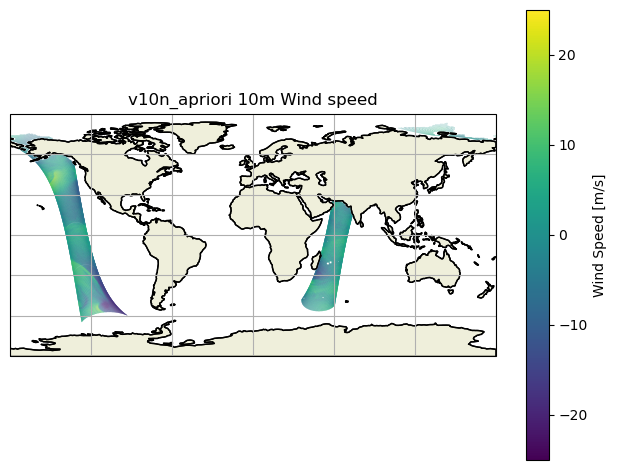

In [22]:


reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
support_routines.get_Sat_frame(\
                               SAT_ds.sel(
    time=slice(init_time,end_time)), area_def_world, chan=-1, 
                               var = variable+'_apriori', 
                               begin_t=None, end_t=None)

support_routines.basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                                   'test_times', area_def_world, vmin=-25, vmax=25,
                              proj="PlateCarree",var=variable+'_apriori')

At this point we have our ECMWF data resampled/interpolated in space/time and so the data is ready to use; lets visualize a few results.

First, lets create an area of interest to plot, in this case I want to plot some of the computed variables on the entire globe:


In [ ]:
grid_lons_interest, grid_lats_interest = area_def_world.get_lonlats()
ds = SAT_ds.merge(apriori_da).sel(
    time=slice(init_time,end_time))
swathDef = SwathDefinition(lons=ds.lon.to_numpy(), lats=ds.lat.to_numpy())
lon_scene, lat_scene = swathDef.get_lonlats()

reduced_lon_scene, reduced_lat_scene, reduced_data_scene = \
                           data_reduce.swath_from_lonlat_grid(
            grid_lons_interest, grid_lats_interest,
            lon_scene, lat_scene, ds[variable+'_apriori'][:,:].compute().to_numpy(),
            radius_of_influence=3000)

In [ ]:
ds[variable+'_apriori'].chunk({"time": None,"scene_across_track": None}).compute()

In [ ]:
area_def_world = load_area('areas.yaml', 'worldeqc30km')# 'worldeqc30km70') # for plots


Lets visualize our observations (remember we selected a subset or **batch**):

In [ ]:

for channel in range(4):
    reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
    support_routines.get_Sat_frame(work_SAT_ds, area_def_world, chan=channel, 
              var = 'tb', begin_t=None, end_t=None)    
    support_routines.basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'scene_channel_'+str(channel), area_def_world, vmin=130, vmax=270,
                                      proj="Orthographic", 
                                       var = 'Channel: '+str(work_SAT_ds.central_freq[channel].values)+' '+
                                       str(work_SAT_ds.central_freq[channel].units)+' '+
                                      str(work_SAT_ds.polarization[channel].values))

For simplicity in the plotting I have created a single routine (**basicMapPlotScat1**) for plotting *swath* data (i.e. non regular grid data), we can visualize observations but also the resampled (and in the end, interpolated) variables; argument *chan* in the plotting routine will tell the routine wheter I want to visualize observations (*swath* + *channel*), resampled variables (*swath* + *time4interpolation*) or resampled **and** time interpolated variables (*swath* only).

Now lets check the spatially resampled *u* component of the wind speed (i.e. not interpolated in time yet); for this I select one of the time slices that I resampled (*time4interpolation*):


In [ ]:
# Plot the resampled (Nearest neighb.) ECMWF data in the new 'grid' 
# (i.e. the satellite swath):

reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
support_routines.get_Sat_frame(work_SAT_ds, area_def_world, chan=3, 
              var = variable+'_spatial', begin_t=None, end_t=None)

support_routines.basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'resampledNN', area_def_world, vmin=-25, vmax=25, 
                                   proj="Orthographic", var = variable+'_spatial')

It seems to produce a good (eye ball metric) resampled variable; lets check the ECMWF's gridded data on the same time slice: 

In [ ]:
# Plot origin data (ECMWF on regular grid, to compare with the resampled one):

fig = plt.figure()
#ax = plt.axes(projection=ccrs.PlateCarree())  #
ax = plt.axes(projection=ccrs.Orthographic(60,-15))
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.coastlines()
ax.gridlines()
work_ECMWF_ds[variable][:,:,3].where(
    work_ECMWF_ds.lsm[:,:,3]==0).plot(ax=ax,
    transform=ccrs.PlateCarree(), cmap="viridis",
                                     vmin=-25, vmax=25)
plt.tight_layout()
plt.show()
#plt.savefig('allWind_and_swath.png', bbox_inches='tight', dpi=300) 

Now lets visualize the difference between the *Gaussian Nearest* and *Nearest Neighbours* methods in the **final resampled/interpolated (i.e. space/time)** variables:

In [ ]:

reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
support_routines.get_Sat_frame(work_SAT_ds, area_def_world, chan=-1, 
              var = variable+'_apriori', begin_t=None, end_t=None)

support_routines.basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'spaceTimeInterpolated', area_def_world, vmin=-25, vmax=25,
                                  proj="Orthographic",var=variable+'_apriori')

Sometimes we are interested in focusing on a specific region or location; we can do that by *zooming in* into the specific *area of interest*.
We can create such area (afterwards interpretable using *Cartopy*) by defining a bounding box of *min/max* longitudes and latitudes. We select a *eqc* projection ([Plate Carree](https://proj.org/operations/projections/eqc.html) projection) as default. The datum defines the ellipsoid used in the transformations. 

I provide this auxiliary way of plotting specific regions, but it is by no means generic, its intended as a way to help visualize your data and it can definitely be improved!

In [ ]:
corners = {"min_lon": 35 , "max_lon": 75, "min_lat": -30 , "max_lat": +30, "lat_0": 0, "lon_0":0}
proj_id = 'eqc'  # eqc
datum = 'WGS84'
area_interest = support_routines.defineArea(corners, proj_id, datum)

Using the *area of interest* that we just defined we proced to get the *frame* (specific lon/lat/data combinations, 3 arrays) and we plot them using the *mapPlotScatZoom* function (in support/support_routines).

In [ ]:
zoom_lon_scene, zoom_lat_scene, zoom_data_scene =\
support_routines.get_Sat_frame(work_SAT_ds, area_interest, chan=-1, 
              var = variable+'_apriori', begin_t=None, end_t=None)

support_routines.mapPlotScatZoom(zoom_lon_scene, zoom_lat_scene, zoom_data_scene,
                 variable+'_zoomPlot', -25,25,var=variable+'_apriori', area=area_interest)